# *Monod* demonstration: distinguishing models of transcriptional variation

We ran the *Monod* inference pipeline on thirteen datasets: pre-clustered mouse brain cell data, disaggregated into GABAergic and glutamatergic cell types, and five 10X Genomics mouse tissue samples. Each dataset was fit using the bursty, constitutive, extrinsic, and CIR models for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given maximum likelihood estimates under each model, we can apply the standard Akaike Information Criterion framework to attempt to assign probabilities to the models. These estimates are necessarily incomplete, as they do not take into account the parameter uncertainties; further, they appear to overestimate confidence in model selections. However, this is an essential first step toward exploring model ensembles. 

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [3]:
import time
t1 = time.time()

In [6]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')


In [14]:
import monod
from monod.preprocess import *
from monod.extract_data import extract_data
import monod.cme_toolbox as cme_toolbox
from monod.cme_toolbox import CMEModel
import monod.inference as inference
from monod.inference import InferenceParameters, GradientInference
import monod.analysis as analysis
from monod.analysis import *

sys.modules['extract_data']=monod.extract_data
sys.modules['inference']=inference
sys.modules['cme_toolbox']=cme_toolbox
sys.modules['analysis']=analysis


In [8]:
models = ('Bursty','Extrinsic','CIR')
n_models = len(models)

In [9]:
# n_models = len(models)

In [10]:
dataset_meta = ['B08','C01','F08','H12']
subcluster_names = ['l23it','l5it','l6it','l5et', 'l56np', 'l6ct', 'l6b']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 

dir_string = './fits/gg_220602_022_allen_celltypes_1'
n_datasets = len(dataset_names)


In [11]:
dir_string = './fits/gg_220602_022_allen_celltypes_1'
result_strings = [[dir_string+'/'+x+'/'+y+'_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names] \
                  for y in models]
sd_strings = [dir_string+'/'+x+'/raw.sd' for x in dataset_names]

# res = [dir_string1+'/'+x for x in dn1]

# dn2 =  ['heart_1k','heart_10k','neuron_1k','neuron_10k','brain_5k']
# dn2 = [x+'_v3' for x in dn2]
# dataset_names = dn1 + dn2

# dir_string2 = './fits/gg_220526_021_modelcomp_1'
# res += [dir_string2+'/'+x for x in dn2]

# result_strings = [[x+'/'+model+'_Poisson_20x21/grid_scan_results.res' for model in models] for x in res]

# sd_strings = [dir_string1+'/'+x+'/raw.sd' for x in dn1] + [dir_string2+'/'+x+'/raw.sd' for x in dn2]


In [12]:
result_strings

[['./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5et/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l56np/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6ct/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6b/Bursty_Poisson_20x21/grid_scan_results_upd.res'],
 ['./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltyp

In [15]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr_ = []
    for k in range(n_models):
        sr_.append(load_search_results(result_strings[k][j]))
    
    sd_arr.append(sd)
    sr_arr.append(sr_)


INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/CIR_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5

In [16]:
len(sr_arr)

7

## AIC weight computation

Now, we iterate over the results for all of the models, identify the parameter optima, and compute Akaike weights according to the procedure in Burnham and Anderson (2002).

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l23it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5et.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l56np.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6ct.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6b.png.


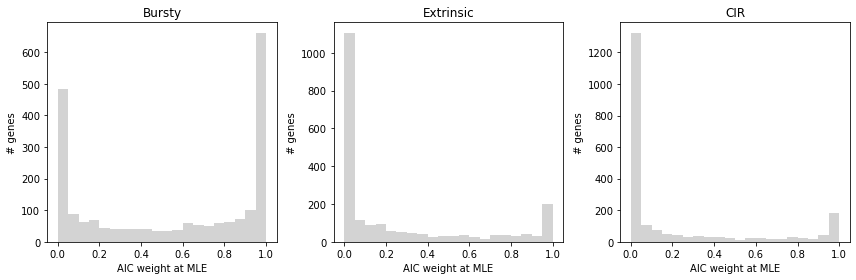

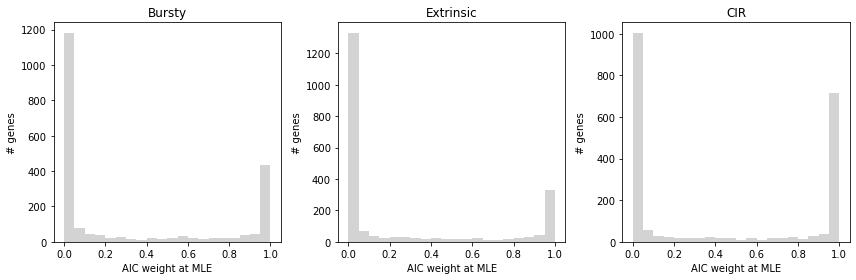

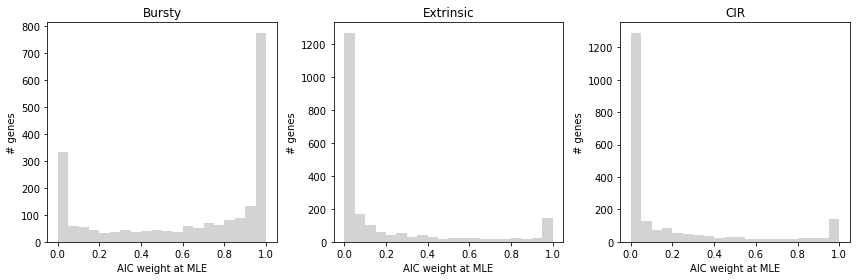

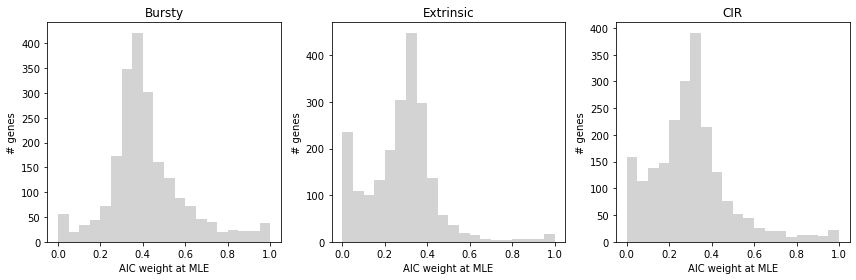

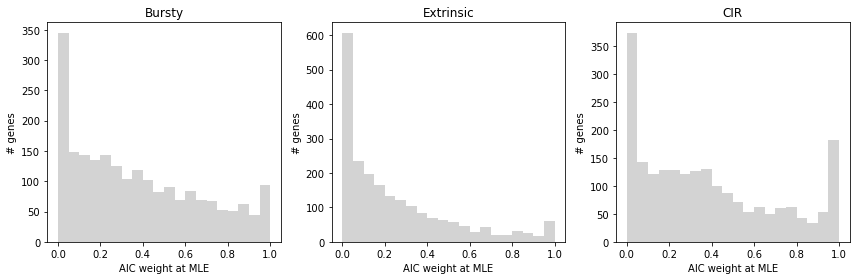

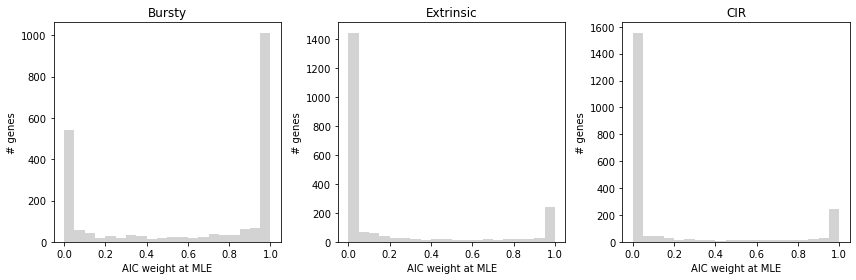

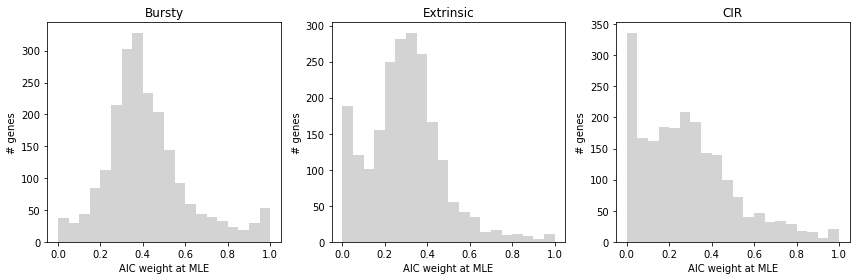

In [69]:
w = []

for j in range(n_datasets):
    w_ = plot_AIC_weights(sr_arr[j],sd_arr[j],models,meta=dataset_names[j],savefig=True)
    w.append(w_)

We find that the constitutive model is essentially never selected as the optimal one; biological overdispersion is clearly mandatory to describe scRNA-seq joint distributions. However, surprisingly, we find quite a bit of variation in *which* overdispersed model is optimal.

In [73]:
w = np.asarray(w)

In [19]:
w.shape

(7, 3, 2130)

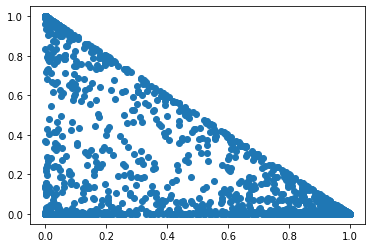

In [20]:
plt.scatter(w[0,0],w[0,2])

In [21]:
# import importlib
# importlib.reload(plotly)

In [22]:
import plotly
import plotly.express as px
import pandas as pd

In [23]:
import ternary


In [80]:
w.shape

(7, 3, 2130)

In [74]:
w_  = w[np.asarray([0,1,3,4,5]),:,:]

In [90]:
w_ = w[n_cells>100,:,:]

In [58]:
w.shape

(5, 3, 2130)

In [24]:
np.asarray([x.n_cells for x in sd_arr])

array([ 621, 1702,  471,   57,  191, 1359,   34])

In [92]:
gf_cir = (w_[:,2,:]>0.8).all(0)
gf_gou = (w_[:,0,:]>0.8).all(0)
gf_ext = (w_[:,1,:]>0.8).all(0)

In [103]:
thr = 0.95
gf_cir = (w_[:,2,:]>thr).all(0)
gf_gou = (w_[:,0,:]>thr).all(0)
gf_ext = (w_[:,1,:]>thr).all(0)

In [91]:
gf_cir = (w[:,2,:]>0.8).all(0)
gf_gou = (w[:,0,:]>0.8).all(0)
gf_ext = (w[:,1,:]>0.8).all(0)

In [82]:
gn = sd_arr[0].gene_names

In [104]:
gn[gf_cir]

array(['Cox6b1', 'Cpe', 'Grin3a', 'Hspa8', 'Mdh1', 'Mgst3', 'Ndfip1',
       'P4ha1', 'Rtn4', 'Slc24a3', 'Slc2a13', 'Stmn2', 'Stmn3', 'Trnp1',
       'Uchl1', 'Vapa', 'Ywhaq'], dtype='<U16')

In [105]:
gn[gf_gou]

array(['Adcy2', 'Csmd2', 'D430041D05Rik', 'Dennd5b', 'Dip2b', 'Efna5',
       'Hlf', 'Ildr2', 'Meg3', 'Plxna4', 'Prune2', 'Purg', 'Ralgapa2'],
      dtype='<U16')

In [106]:
gn[gf_cir]

array(['Cox6b1', 'Cpe', 'Grin3a', 'Hspa8', 'Mdh1', 'Mgst3', 'Ndfip1',
       'P4ha1', 'Rtn4', 'Slc24a3', 'Slc2a13', 'Stmn2', 'Stmn3', 'Trnp1',
       'Uchl1', 'Vapa', 'Ywhaq'], dtype='<U16')

In [109]:
gf_cir.sum()

17

In [110]:
gf_gou.sum()

13

In [112]:
gf_ext.sum()

22

In [28]:
sr_arr[0]

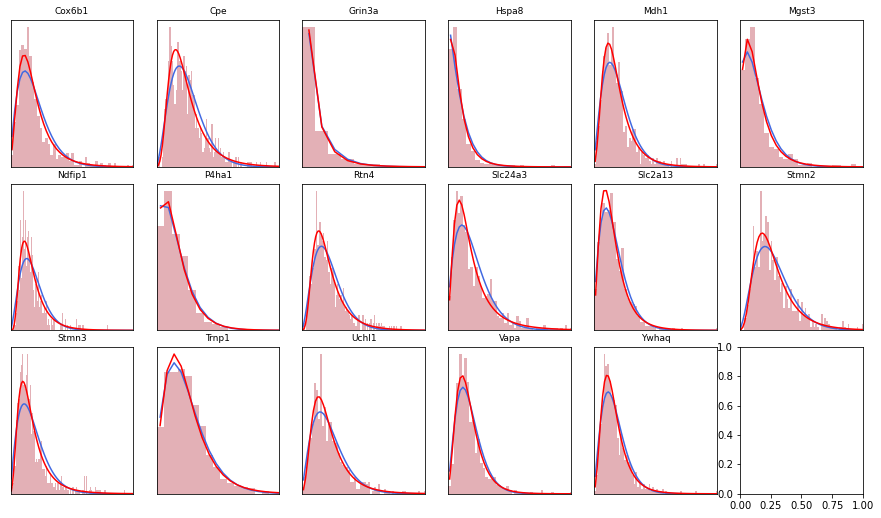

In [115]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_cir,sz=(3,6),figsize=(12,7),
                           marg='mature')

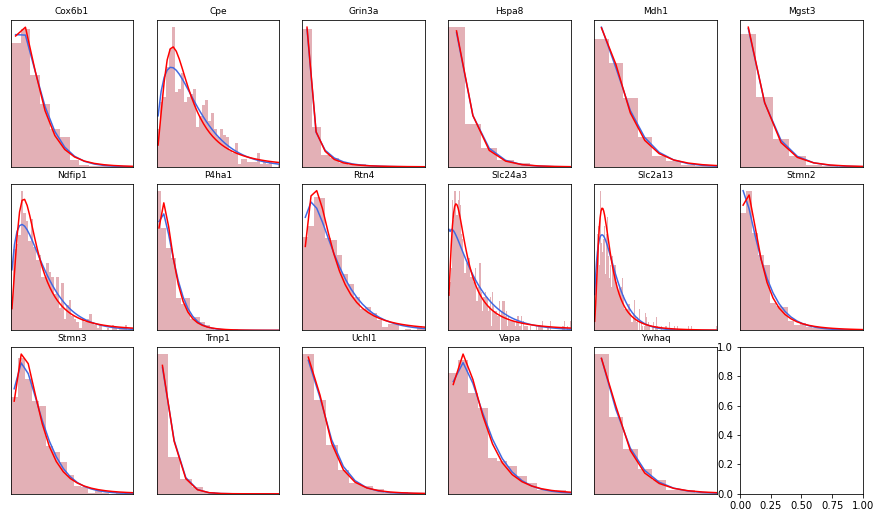

In [118]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_cir,sz=(3,6),figsize=(12,7),
                          marg='nascent')

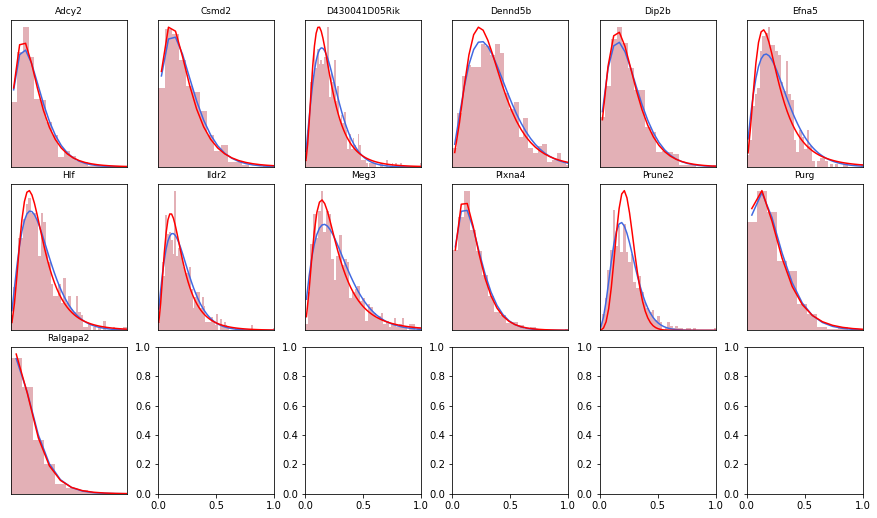

In [119]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_gou,sz=(3,6),figsize=(12,7),
                           marg='mature')

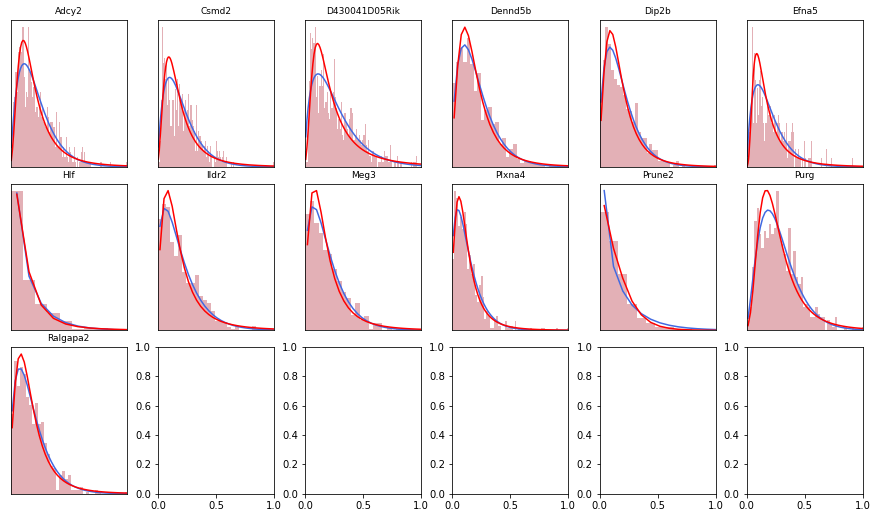

In [120]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_gou,sz=(3,6),figsize=(12,7),
                           marg='nascent')

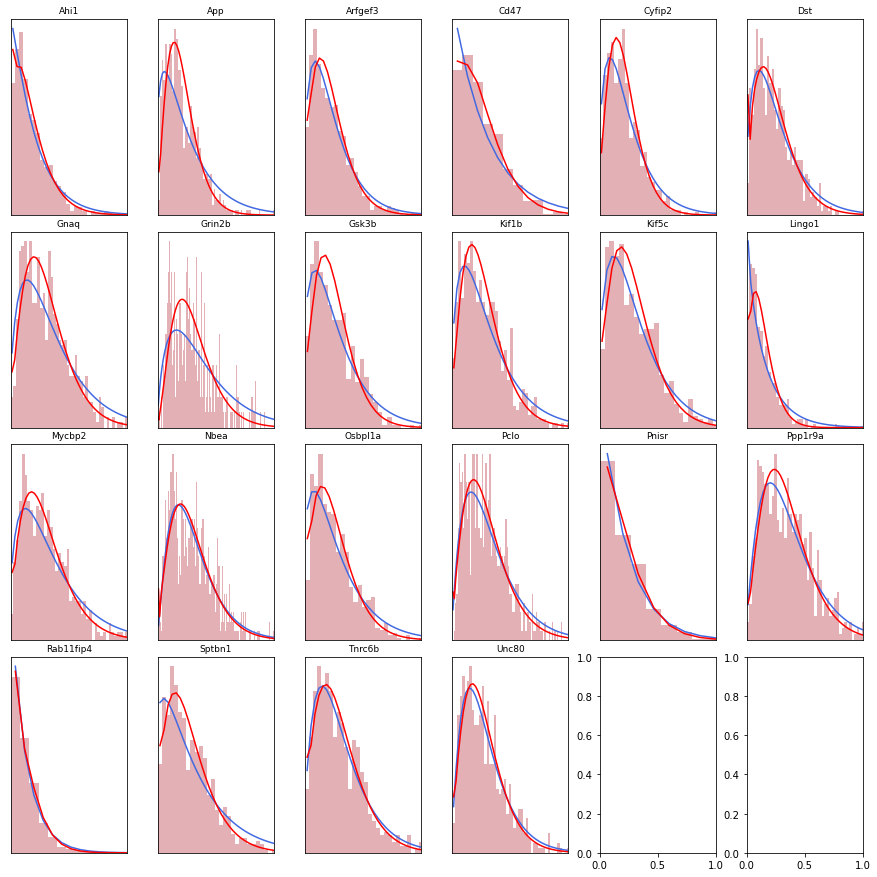

In [122]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][1]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_ext,sz=(4,6),figsize=(12,12),
                           marg='nascent')

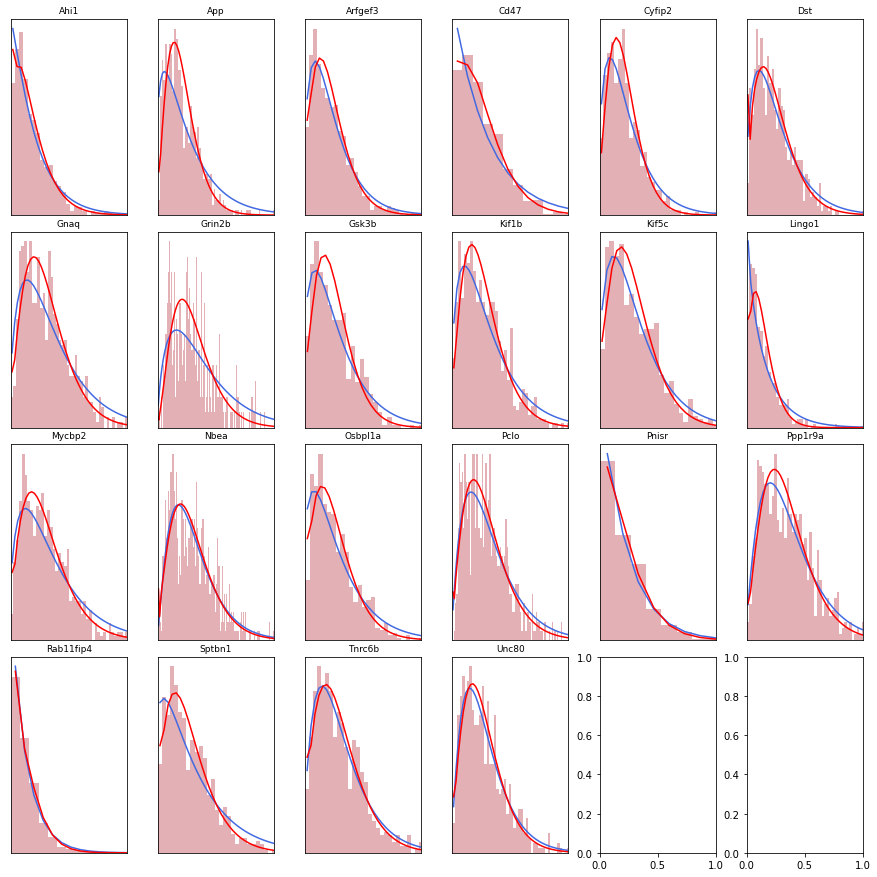

In [121]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][1]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_ext,sz=(4,6),figsize=(12,12),
                           marg='nascent')

In [52]:
n_cells

array([0.14002255, 0.3837655 , 0.10620068, 0.01285231, 0.04306652,
       0.30642616, 0.00766629])

In [31]:
gf_burst = (w[:,0,:]>0.6).all(0)

In [32]:
gn[gf_burst]

array(['Atxn1', 'D430041D05Rik', 'Gria2', 'Igf1r', 'Nfasc', 'Rbfox3',
       'Rims1', 'Sez6l', 'Slc35f1', 'Trhde'], dtype='<U16')

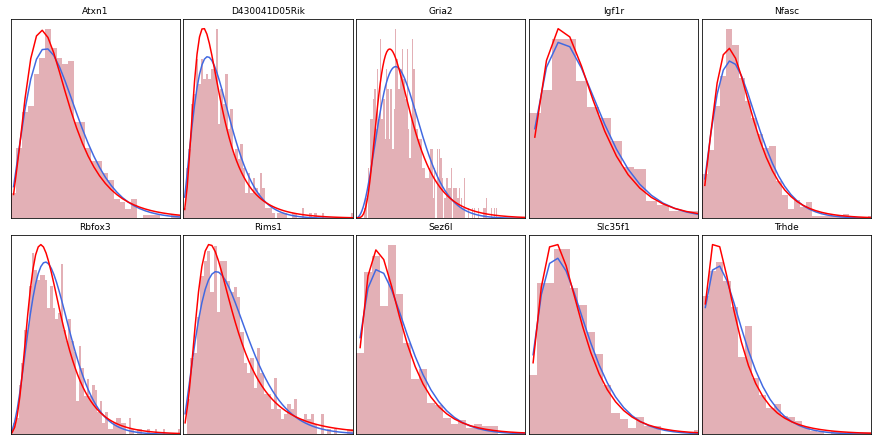

In [33]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_burst,sz=(2,5),figsize=(12,6),
                           marg='mature')

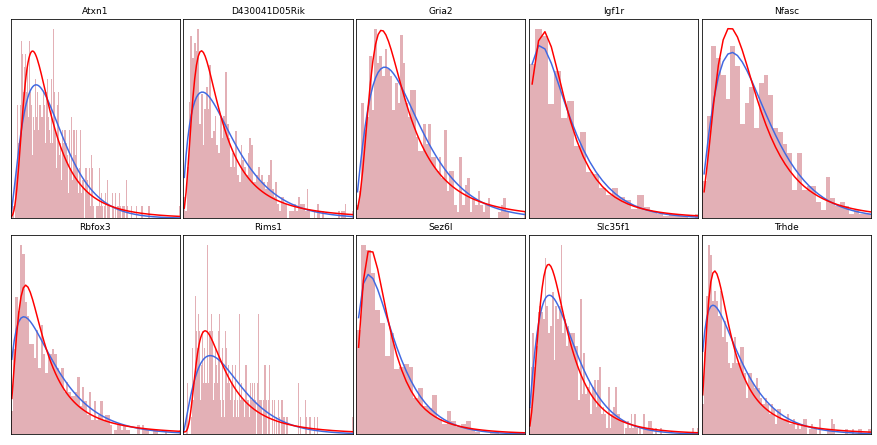

In [34]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_burst,sz=(2,5),figsize=(12,6),
                           marg='nascent')

In [55]:
n_cells

array([ 621, 1702,  471,   57,  191, 1359,   34])

In [53]:
n_cells = np.asarray([x.n_cells for x in sd_arr])
# n_cells = n_cells/n_cells.sum()
w_mean = (w*n_cells[:,None,None]/n_cells.sum()).sum(0)

In [36]:
w_mean.shape

(3, 2130)

In [37]:
df = pd.DataFrame(data={models[k]:w_mean[k] for k in range(len(models))} )

In [38]:
df

Bursty  Extrinsic       CIR
0     0.939079   0.013615  0.047305
1     0.765029   0.103356  0.131615
2     0.559727   0.009291  0.430982
3     0.201107   0.794175  0.004718
4     0.459532   0.057437  0.483031
...        ...        ...       ...
2125  0.007646   0.627067  0.365287
2126  0.039728   0.955695  0.004577
2127  0.091669   0.014163  0.894169
2128  0.586675   0.013617  0.399708
2129  0.934732   0.036161  0.029107

[2130 rows x 3 columns]

In [39]:
w_mean.min()

1.7005909108799088e-09

In [40]:
fig = px.scatter_ternary(df,a=models[0],b=models[1],c=models[2])
fig.show()

In [41]:
import plotly.figure_factory as ff


In [42]:
kde = scipy.stats.gaussian_kde(w_mean[:2],bw_method=0.1)

In [43]:
# np.vstack((a,b)).shape

In [44]:
kde([0,1])

array([3.64628118])

In [45]:
a, b = np.mgrid[0:1:20j, 0:1:20j]
mask = a + b <= 1
a = a[mask].ravel()
b = b[mask].ravel()
c = 1 - a - b
# Values to be displayed as contours
# z = a * b * c
z=kde(np.vstack((a,b)))
fig = ff.create_ternary_contour(np.stack((a, b, c)), z,ncontours=6,colorscale='Cividis',pole_labels=models,\
                               coloring=None)
fig.show()


So: `w` contains the dataset on the first axis, model (bursty, extrinsic, CIR-like) on second, gene on third.

In [46]:
w.shape

(7, 3, 2130)

In [47]:
dataset_names

['allen_B08_l23it',
 'allen_B08_l5it',
 'allen_B08_l6it',
 'allen_B08_l5et',
 'allen_B08_l56np',
 'allen_B08_l6ct',
 'allen_B08_l6b']

In [48]:
models

('Bursty', 'Extrinsic', 'CIR')

In [49]:
gn

array(['1700025G04Rik', '1810013L24Rik', '2010300C02Rik', ..., 'Zwint',
       'Zyg11b', 'Zzef1'], dtype='<U16')

In [50]:
n_cells_raw = [x.n_cells for x in sd_arr]
print(n_cells_raw)

[621, 1702, 471, 57, 191, 1359, 34]


In [51]:
import pickle

In [55]:
pickle.dump((w,dataset_names,models,gn),open('/home/ggorin/projects/GVFP_2021/loom/weights_and_genes.pickle','wb'))

check it

In [56]:
pickle.load(open('/home/ggorin/projects/GVFP_2021/loom/weights_and_genes.pickle','rb'))

(array([[[9.99988364e-01, 2.37195612e-01, 9.94529763e-01, ...,
          1.12651277e-06, 9.53068464e-01, 8.84682119e-01],
         [2.22480652e-06, 1.69285545e-02, 2.60409745e-07, ...,
          1.53652561e-18, 4.69314113e-02, 9.97879823e-02],
         [9.41144625e-06, 7.45875834e-01, 5.46997696e-03, ...,
          9.99998873e-01, 1.24339008e-07, 1.55298982e-02]],
 
        [[9.99131476e-01, 9.71070299e-01, 1.04536883e-08, ...,
          4.22220168e-44, 6.41165603e-07, 9.99996162e-01],
         [1.02995407e-19, 1.57872351e-02, 9.79926397e-21, ...,
          8.12493074e-54, 4.46498596e-09, 7.22329828e-11],
         [8.68523630e-04, 1.31424663e-02, 9.99999990e-01, ...,
          1.00000000e+00, 9.99999354e-01, 3.83806861e-06]],
 
        [[8.24009443e-01, 9.17382367e-01, 9.99538066e-01, ...,
          5.87504354e-01, 9.99983229e-01, 9.92375556e-01],
         [1.28132112e-04, 2.77501202e-02, 8.56825194e-12, ...,
          6.24379622e-10, 1.56951462e-06, 7.59798044e-03],
         [1.758624